In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# basic import
import os
import os.path as op

# python libs
import numpy as np
import xarray as xr
from datetime import datetime, timedelta

# custom libs
from ttide.t_tide import t_tide
from ttide.t_predic import t_predic

# TODO: ACTUALIZAR A LIBRERIA UTIDE
# https://www.eoas.ubc.ca/~rich/#T_Tide

# DEV: override installed teslakit
import sys
sys.path.insert(0, op.join(os.path.abspath(''), '..', '..'))

# teslakit
from teslakit.database import Database
from teslakit.plotting.tides import Plot_AstronomicalTide, Plot_ValidateTTIDE



## Database and Site parameters

In [2]:
# --------------------------------------
# Teslakit database

p_data = r'/Users/nico/Projects/TESLA-kit/TeslaKit/data'
db = Database(p_data)

# set site
db.SetSite('KWAJALEIN')


In [3]:
# --------------------------------------
# Load astronomical tide historical and set simulation dates

xds_atide = db.Load_TIDE_hist_astro()

# Simulation dates
d1_sim = np.datetime64('1700-01-01')
d2_sim = np.datetime64('1800-01-01')



## Astronomical Tide

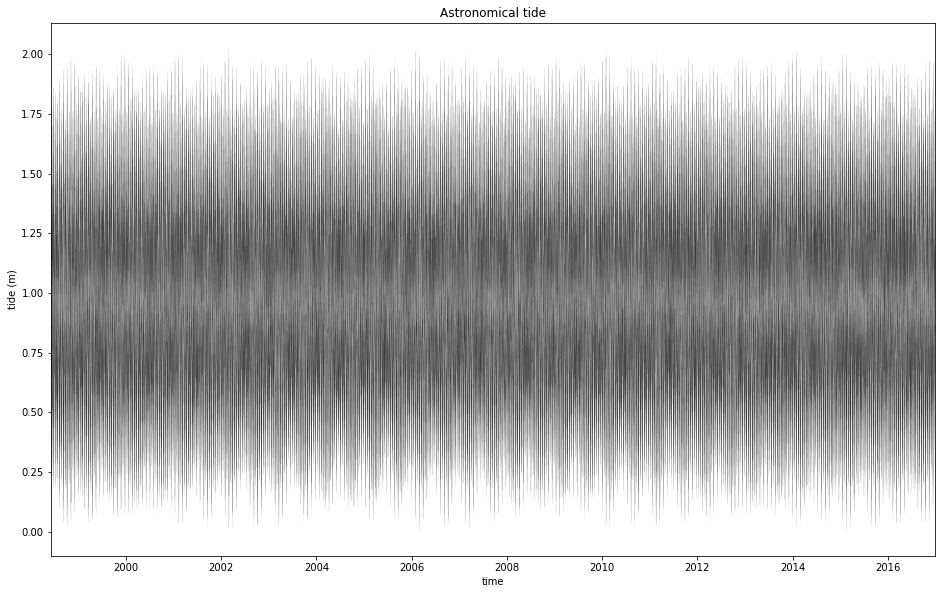

In [4]:
# --------------------------------------
# astronomical tide data

# remove tide nanmin
xds_atide['tide'] = xds_atide.tide - np.nanmin(xds_atide.tide)

# data length has to be lesser than 18.6 years
dt_cut = np.datetime64('1998-06-01')
xds_atide = xds_atide.where(xds_atide.time >= dt_cut, drop=True)

# Plot astronomical tide
time = xds_atide.time.values[:]
tide = xds_atide.tide.values[:]
Plot_AstronomicalTide(time, tide)



## Astronomical Tide - Fitting

In [5]:
# --------------------------------------
# t_tide library - Fit

# TODO: ttide ha de se calibrada con un year de datos (no 18.6)
lat0 = 9.75
d_out = t_tide(xds_atide.tide.values, dt=1, lat=np.array(lat0))

# variables used for prediction
names = d_out['nameu']
freq = d_out['fu']
tidecon = d_out['tidecon']

-----------------------------------
nobs = 162936 
ngood = 162935 
record length (days) = 6789.00
rayleigh criterion = 1.0

Phases at central time
x0= 0.954  xtrend= 0
var(data)= 0.17    var(prediction)= 0.17    var(residual)= 0.00
var(prediction)/var(data) (%) = 99.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
  SA    0.0001141     0.0000     0.000     84.27    291.65   0.00039
  SSA   0.0002282     0.0000     0.000    325.95    269.49   0.00027
  MSM   0.0013098     0.0000     0.000    239.18    264.34   0.00068
* MM    0.0015122     0.0070     0.000    180.43      2.83   3.6e+02
  MSF   0.0028219     0.0000     0.000    267.56    280.80    0.0082
* MF    0.0030501     0.0113     0.000    281.19      1.96     1e+03
  ALP1  0.0343966     0.0000     0.000     57.77    265.96   0.00016
* 2Q1   0.0357064     0.0015     0.001    245.28     24.67       5.8
  SIG1  0.0359087     0.0000     0.000    209.84    270

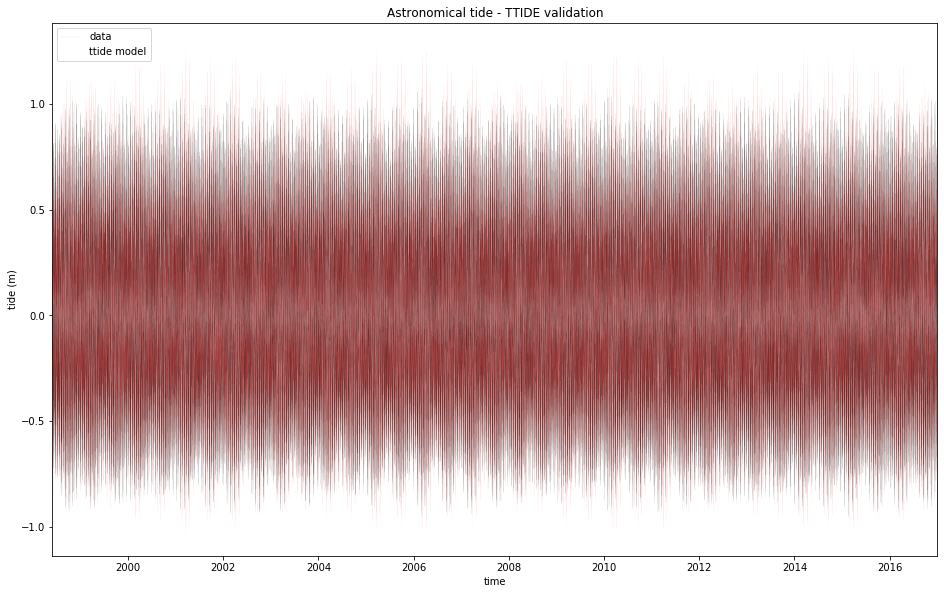

In [6]:
# --------------------------------------
# t_tide library - Validation

d1_val = xds_atide.time.values[0]
d2_val = xds_atide.time.values[-1]
date_val = np.arange(d1_val, d2_val, dtype='datetime64[h]')
tide_tt = t_predic(
    date_val, names, freq, tidecon,
    lat=lat0, ltype='nodal')

# Plot ttide validation 
time = xds_atide.time.values[:-1]
tide = xds_atide.tide.values[:-1]
tide = tide - np.nanmean(tide)
Plot_ValidateTTIDE(time, tide, tide_tt)



## Astronomical Tide - Prediction

In [7]:
# --------------------------------------
# t_tide library - Prediction

date_pred = np.arange(d1_sim, d2_sim, dtype='datetime64[h]')
atide_pred = t_predic(
    date_pred, names, freq, tidecon,
    lat=lat0, ltype='nodal')

# Store data
dt_pred = [d.astype(datetime) for d in date_pred]
xds_atide_sim = xr.Dataset(
    {
        'tide'   :(('time',), atide_pred),
    },
    {'time' : dt_pred}
)

print(xds_atide_sim)

db.Save_TIDE_sim_astro(xds_atide_sim)


<xarray.Dataset>
Dimensions:  (time: 876576)
Coordinates:
  * time     (time) datetime64[ns] 1700-01-01 ... 1799-12-31T23:00:00
Data variables:
    tide     (time) float64 -0.6228 -0.5077 -0.2677 ... 0.02958 0.215 0.378


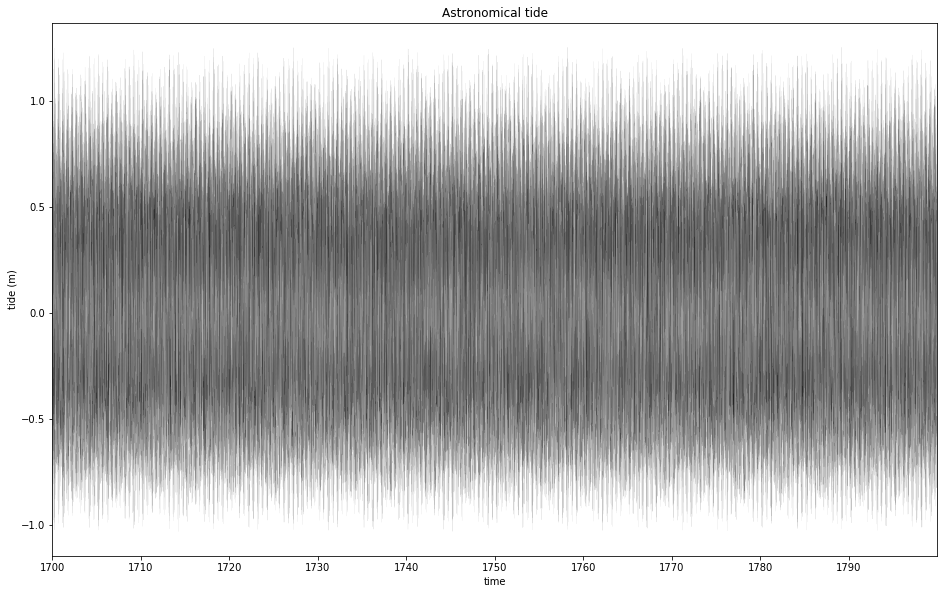

In [8]:
# Plot astronomical tide prediction
time = xds_atide_sim.time.values[:]
tide = xds_atide_sim.tide.values[:]

Plot_AstronomicalTide(time, tide)
